<a href="https://colab.research.google.com/github/CodeMaverick-143/Instagram_Analytics/blob/main/Instagram_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instagram Analytics

### Import and setup

In [38]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler

file_path = "Instagram_Analytics.csv"

# 1. Load Data & Basic Understanding

In [39]:
df = pd.read_csv(file_path)

print("Shape of dataset:", df.shape)
display(df.head())

print("\nInfo:")
print(df.info())

print("\nBasic stats (numeric):")
display(df.describe())

Shape of dataset: (29999, 15)


,post_id,upload_date,media_type,likes,comments,shares,saves,reach,impressions,caption_length,hashtags_count,followers_gained,traffic_source,engagement_rate,content_category
0,IG0000001,2024-11-30 09:25:22.954916,Reel,31627,7559,4530,6393,615036,1007750,1340,3,899,Home Feed,4.97,Technology
1,IG0000002,2025-08-15 09:25:22.954916,Photo,63206,3490,1680,6809,1237071,1345900,1351,20,805,Hashtags,5.59,Fitness
2,IG0000003,2025-09-11 09:25:22.954916,Reel,94373,3727,1761,8367,1127470,1305369,242,24,758,Reels Feed,8.29,Beauty
3,IG0000004,2025-09-18 09:25:22.954916,Reel,172053,7222,2875,9290,764030,897874,446,11,402,External,21.32,Music
4,IG0000005,2025-03-21 09:25:22.954916,Video,99646,2703,4444,9746,7004,495406,1905,8,155,Profile,23.52,Technology



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   post_id           29999 non-null  object 
 1   upload_date       29999 non-null  object 
 2   media_type        29999 non-null  object 
 3   likes             29999 non-null  int64  
 4   comments          29999 non-null  int64  
 5   shares            29999 non-null  int64  
 6   saves             29999 non-null  int64  
 7   reach             29999 non-null  int64  
 8   impressions       29999 non-null  int64  
 9   caption_length    29999 non-null  int64  
 10  hashtags_count    29999 non-null  int64  
 11  followers_gained  29999 non-null  int64  
 12  traffic_source    29999 non-null  object 
 13  engagement_rate   29999 non-null  float64
 14  content_category  29999 non-null  object 
dtypes: float64(1), int64(9), object(5)
memory usage: 3.4+ MB
None

Basic stats (nume

,likes,comments,shares,saves,reach,impressions,caption_length,hashtags_count,followers_gained,engagement_rate
count,29999.000000,29999.000000,29999.000000,29999.000000,2.999900e+04,2.999900e+04,29999.000000,29999.000000,29999.000000,29999.000000
mean,99912.661789,5017.781426,2502.912564,7490.124637,9.965616e+05,1.246669e+06,1103.110904,14.887430,502.152805,14.419276
std,57905.967401,2888.404881,1448.320395,4352.546949,5.777906e+05,5.970924e+05,635.991308,9.005811,290.364038,29.660210
min,7.000000,0.000000,0.000000,0.000000,1.650000e+02,5.107000e+03,0.000000,0.000000,0.000000,0.120000
25%,49755.000000,2530.500000,1246.000000,3690.500000,4.936810e+05,7.469585e+05,555.000000,7.000000,251.000000,5.180000
50%,99580.000000,5042.000000,2498.000000,7483.000000,9.921810e+05,1.241026e+06,1100.000000,15.000000,501.000000,9.190000
75%,150225.000000,7518.000000,3768.000000,11294.000000,1.494798e+06,1.749264e+06,1656.000000,23.000000,755.000000,15.670000
max,200000.000000,10000.000000,5000.000000,15000.000000,1.999865e+06,2.497940e+06,2200.000000,30.000000,1000.000000,3259.820000


## 2. Data Cleaning

### 2.1 Handle Dates

In [40]:
df['upload_date'] = pd.to_datetime(df['upload_date'], errors='coerce')

print("Missing dates:", df['upload_date'].isna().sum())

df = df.dropna(subset=['upload_date'])

df['Year'] = df['upload_date'].dt.year
df['Month'] = df['upload_date'].dt.month
df['Day'] = df['upload_date'].dt.day
df['Weekday'] = df['upload_date'].dt.weekday

Missing dates: 0


### 2.2 Check Missing Values

In [41]:
missing = df.isna().sum().sort_values(ascending=False)
print("Missing values per column:")
print(missing)

Missing values per column:
post_id             0
upload_date         0
media_type          0
likes               0
comments            0
shares              0
saves               0
reach               0
impressions         0
caption_length      0
hashtags_count      0
followers_gained    0
traffic_source      0
engagement_rate     0
content_category    0
Year                0
Month               0
Day                 0
Weekday             0
dtype: int64


In [42]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

### 2.3 Basic sanity checks

In [43]:
engagement_cols = ['Likes', 'Comments', 'Shares', 'Saves', 'Reach', 'Impressions','Caption_Length', 'Hashtags_Count', 'Followers_Gained']

for col in engagement_cols:
    if col in df.columns:
        print(col, "min:", df[col].min())

# 3. Feature Engineering


### 3.1 Engagement Counts Aggregation

In [44]:
df['Total_Engagement'] = df['likes'] + df['comments'] + df['shares'] + df['saves']

latest_date = df['upload_date'].max()
df['Post_Age_Days'] = (latest_date - df['upload_date']).dt.days

### 3.2 Encode Categorical Columns

In [45]:
cat_cols = []
if 'media_type' in df.columns:
    cat_cols.append('media_type')
if 'traffic_source' in df.columns:
    cat_cols.append('traffic_source')

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("Columns after encoding:")
print(df_encoded.columns)

Columns after encoding:
Index(['post_id', 'upload_date', 'likes', 'comments', 'shares', 'saves',
       'reach', 'impressions', 'caption_length', 'hashtags_count',
       'followers_gained', 'engagement_rate', 'content_category', 'Year',
       'Month', 'Day', 'Weekday', 'Total_Engagement', 'Post_Age_Days',
       'media_type_Photo', 'media_type_Reel', 'media_type_Video',
       'traffic_source_External', 'traffic_source_Hashtags',
       'traffic_source_Home Feed', 'traffic_source_Profile',
       'traffic_source_Reels Feed'],
      dtype='object')


# 4. Exploratory Data Analysis (EDA)

### 4.1 Distribution of Key Metrics

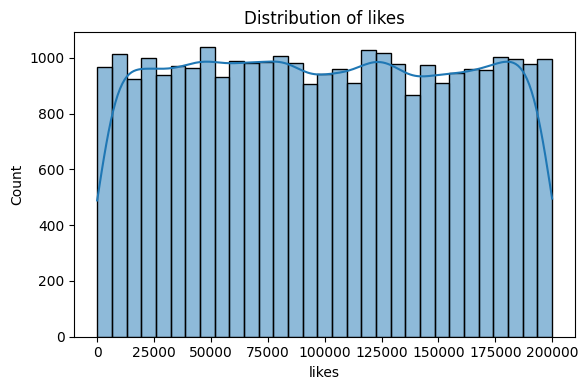

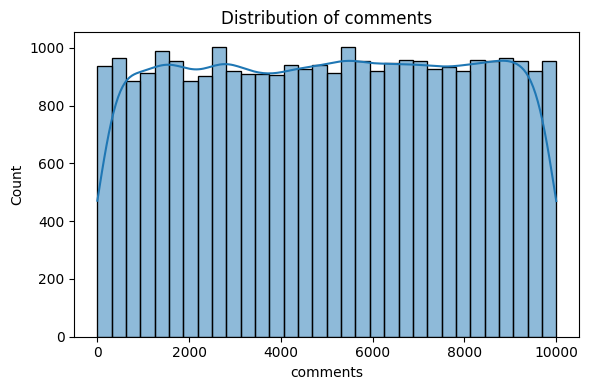

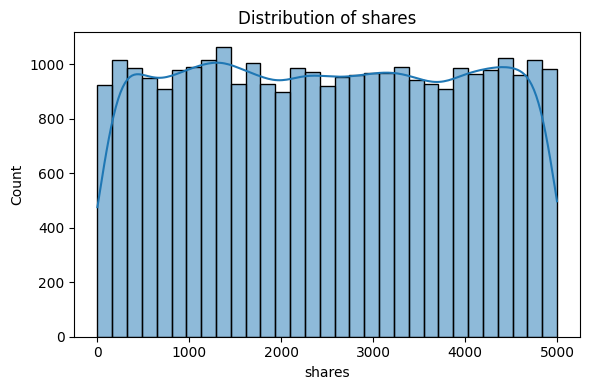

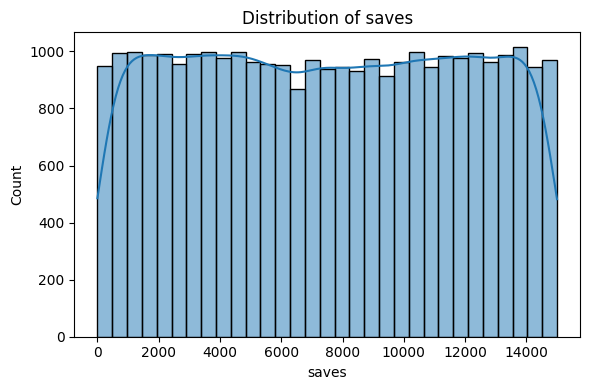

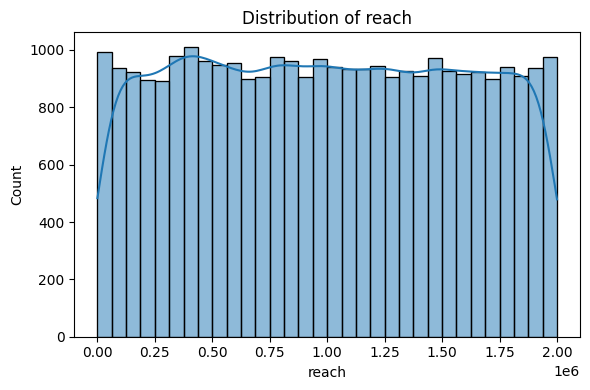

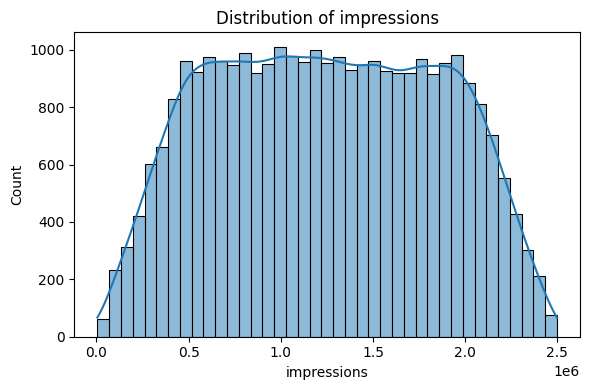

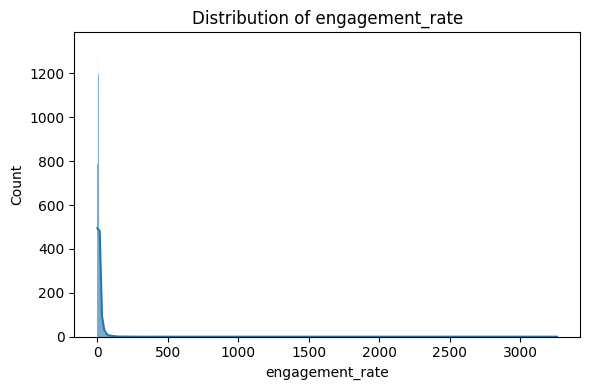

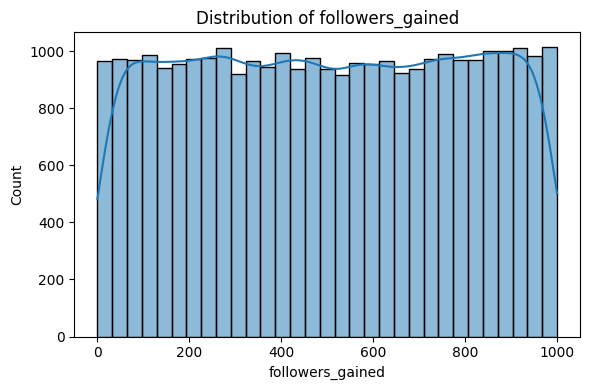

In [46]:
metrics_to_plot = ['likes', 'comments', 'shares', 'saves', 'reach', 'impressions',
                   'engagement_rate', 'followers_gained']

for col in metrics_to_plot:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.tight_layout()
        plt.show()

### 4.2 Media Type vs Performance

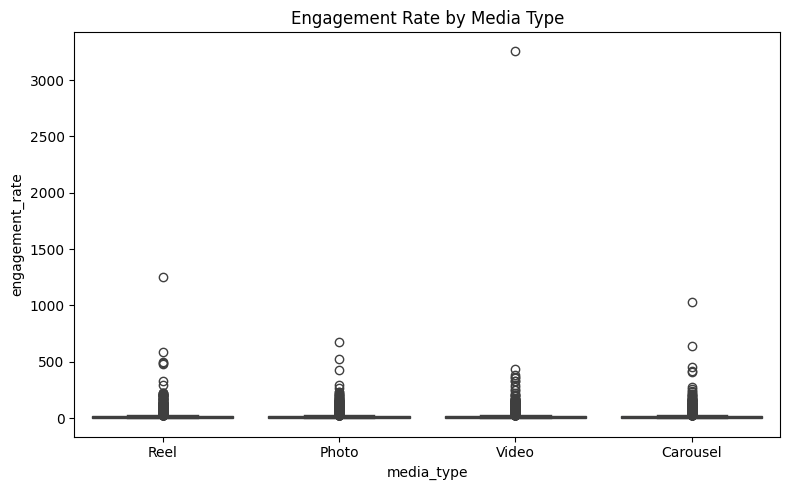

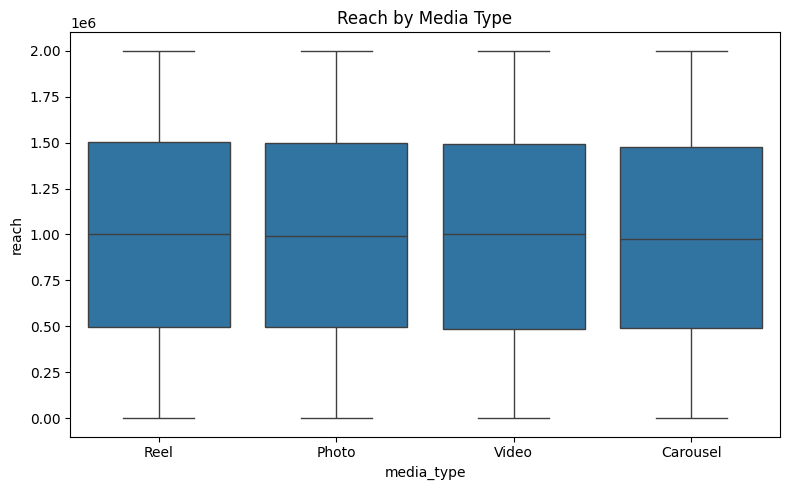

In [47]:
if 'media_type' in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x='media_type', y='engagement_rate')
    plt.title("Engagement Rate by Media Type")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x='media_type', y='reach')
    plt.title("Reach by Media Type")
    plt.tight_layout()
    plt.show()

### 4.3 Traffic Source vs Performance

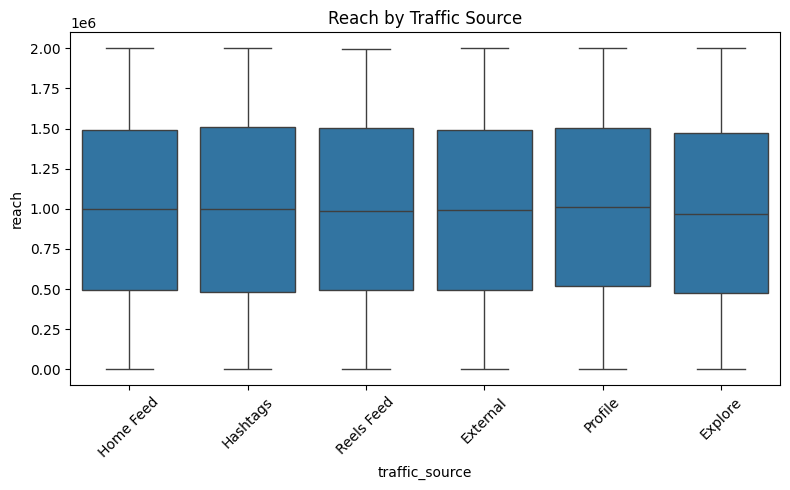

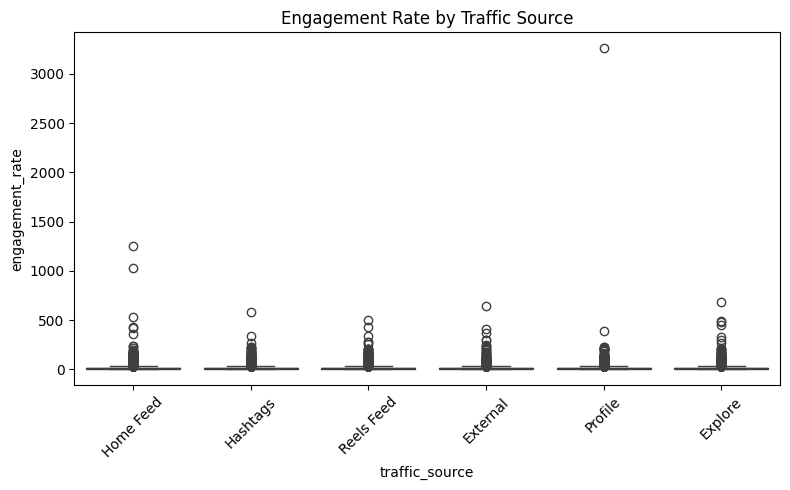

In [48]:
if 'traffic_source' in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x='traffic_source', y='reach')
    plt.title("Reach by Traffic Source")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x='traffic_source', y='engagement_rate')
    plt.title("Engagement Rate by Traffic Source")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 4.4 Hashtags & Caption Length vs Engagement

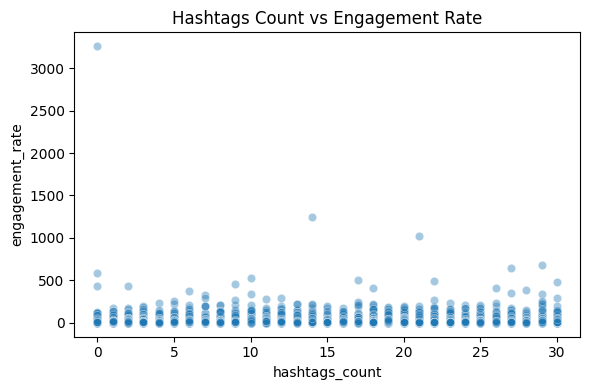

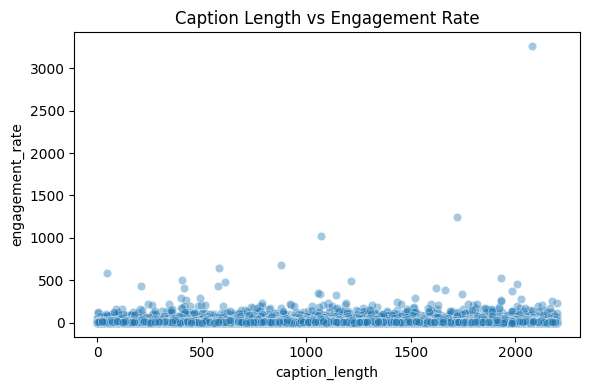

In [49]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='hashtags_count', y='engagement_rate', alpha=0.4)
plt.title("Hashtags Count vs Engagement Rate")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='caption_length', y='engagement_rate', alpha=0.4)
plt.title("Caption Length vs Engagement Rate")
plt.tight_layout()
plt.show()

/tmp/ipython-input-3424458213.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hashtag_group = df.groupby('Hashtag_Bin')['engagement_rate'].mean().reset_index()


,Hashtag_Bin,engagement_rate
0,0-5,13.694723
1,6-10,14.512237
2,11-15,13.697809
3,16-20,14.589294
4,21+,14.572452


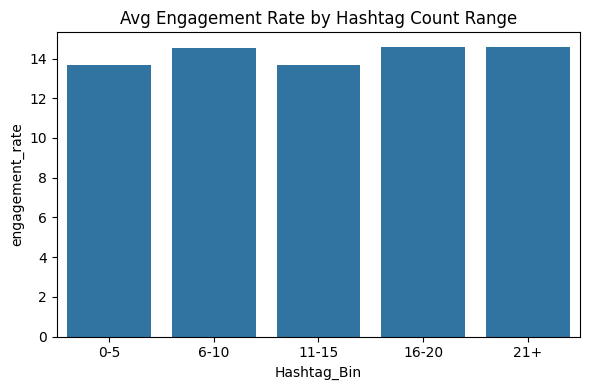

In [50]:
df['Hashtag_Bin'] = pd.cut(df['hashtags_count'], bins=[0,5,10,15,20,50],
                           labels=['0-5','6-10','11-15','16-20','21+'])

hashtag_group = df.groupby('Hashtag_Bin')['engagement_rate'].mean().reset_index()
display(hashtag_group)

plt.figure(figsize=(6,4))
sns.barplot(data=hashtag_group, x='Hashtag_Bin', y='engagement_rate')
plt.title("Avg Engagement Rate by Hashtag Count Range")
plt.tight_layout()
plt.show()

### 4.5 Correlation Heatmap

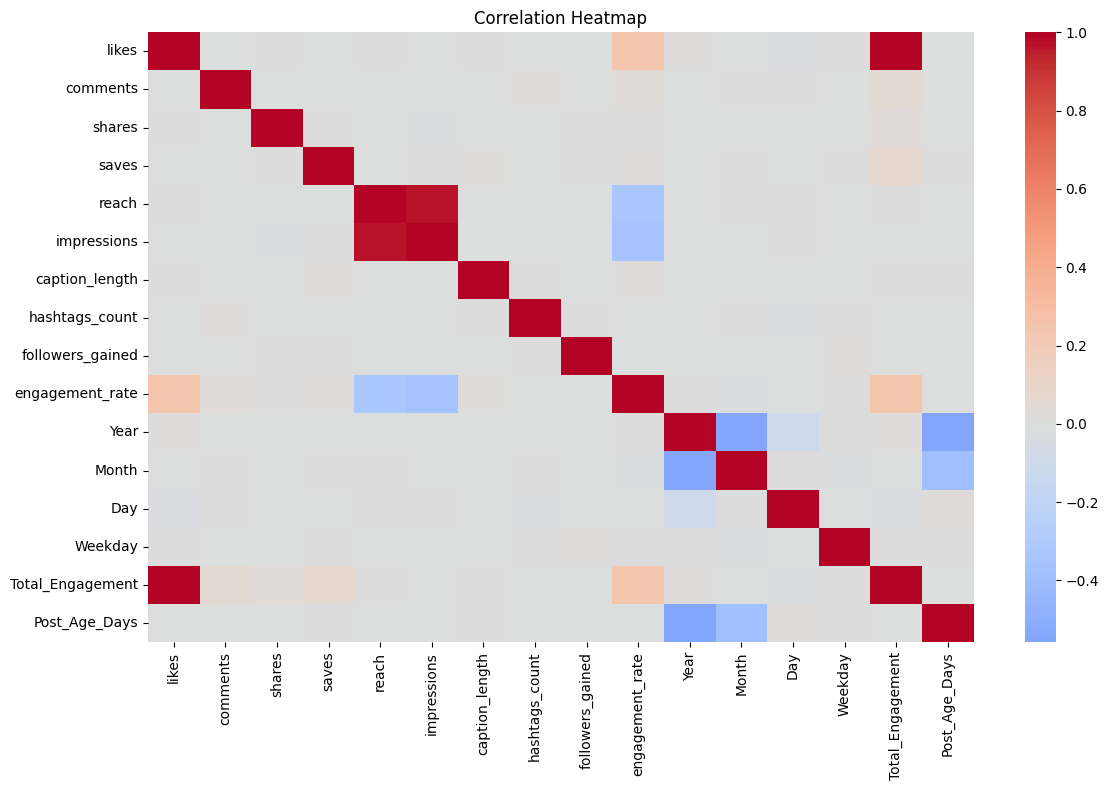

In [51]:
numeric_df = df_encoded.select_dtypes(include=[np.number])

plt.figure(figsize=(12,8))
corr = numeric_df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# 5. Predict Engagement Rate (Regression)


### 5.1 Prepare Features & Target

In [52]:
target_col = 'engagement_rate'

# Identify categorical columns to be encoded (excluding those already handled by get_dummies or dropped)
categorical_features_to_encode = ['content_category']

# Drop identifiers & leakage columns
drop_cols = ['post_id', 'upload_date']  # and any other columns you don't want as features
drop_cols = [col for col in drop_cols if col in df_encoded.columns]

# Apply one-hot encoding to remaining categorical features
X = pd.get_dummies(df_encoded.drop(columns=drop_cols + [target_col]),
                   columns=categorical_features_to_encode,
                   drop_first=True)

y = df_encoded[target_col]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (29999, 32)
y shape: (29999,)


### 5.2 Train-Test Split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 5.3 Train Random Forest Regressor

In [54]:
reg_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Regression MAE:", mae)
print("Regression R^2:", r2)

Regression MAE: 0.7398521083333335
Regression R^2: 0.5902444155488181


### 5.4 Feature Importance (What Drives Engagement?)

,Feature,Importance
5,impressions,0.754903
13,Total_Engagement,0.168051
0,likes,0.059961
3,saves,0.003810
12,Weekday,0.002042
6,caption_length,0.001296
2,shares,0.001163
8,followers_gained,0.001031
1,comments,0.000961
4,reach,0.000959


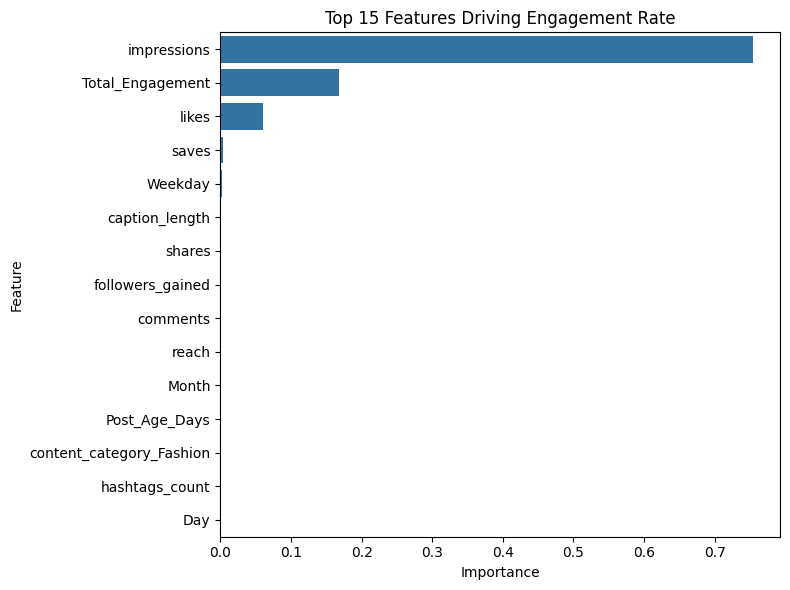

In [55]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': reg_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

display(importances.head(20))

plt.figure(figsize=(8,6))
sns.barplot(data=importances.head(15), x='Importance', y='Feature')
plt.title("Top 15 Features Driving Engagement Rate")
plt.tight_layout()
plt.show()

# 6. Classify High vs Low Performance Posts

### 6.1 Create Target Class

In [56]:
# Using median as threshold
threshold = df['engagement_rate'].median()
print("Engagement threshold (median):", threshold)

df_encoded['Engagement_Class'] = (df_encoded['engagement_rate'] >= threshold).astype(int)

# 1 = High-engagement, 0 = Low-engagement

X_cls = X  # reuse features from before
y_cls = df_encoded['Engagement_Class']

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

Engagement threshold (median): 9.19


### 6.2 Train Classifier

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2997
           1       0.99      0.99      0.99      3003

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



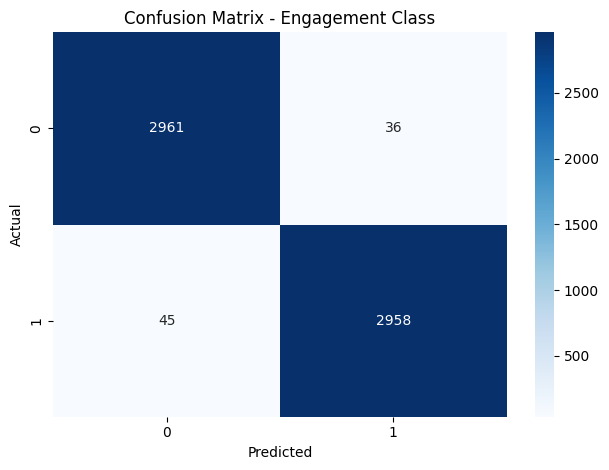

In [57]:
cls_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

cls_model.fit(Xc_train, yc_train)

yc_pred = cls_model.predict(Xc_test)

print("Classification Report:")
print(classification_report(yc_test, yc_pred))

cm = confusion_matrix(yc_test, yc_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Engagement Class")
plt.tight_layout()
plt.show()

# 7. Time/Trend Analysis

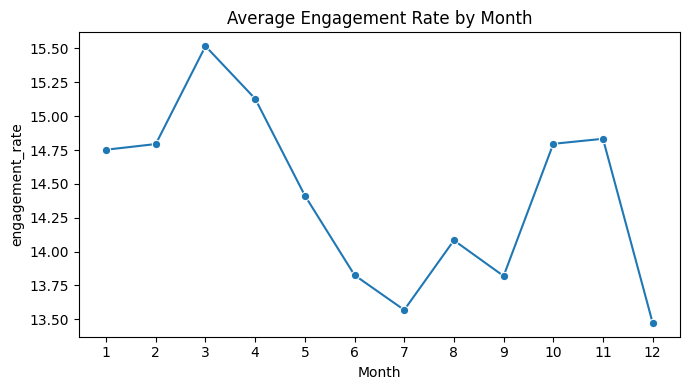

In [58]:
df_time = df.groupby('Month')['engagement_rate'].mean().reset_index()

plt.figure(figsize=(7,4))
sns.lineplot(data=df_time, x='Month', y='engagement_rate', marker='o')
plt.title("Average Engagement Rate by Month")
plt.xticks(df_time['Month'])
plt.tight_layout()
plt.show()